# Convolutional ANN and Transfer learning – D7046E @ LTU.SE

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 100, if this is taking too long on your pc you can decrease it. Just make sure that you use the same hyperparameter values on task 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of "same convolution".
2. Compute and illustrate the resulting image using 3 different convolution filters.

### Task 2
1. Implement a CNN defined, trained and validated on the given dataset. Don't forget to make the train/validation split of the dataset. This can be achieved programatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Implement a data augmentation technique that fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune a pre-trained model on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use a pre-trained model as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import time
import copy

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN which consists of at least one convolutional layer. CNNs are often used where the input size may vary such as when we are dealing with image input. The arcitecture of CNNs were inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built in convolution function. This should function as described in [this blogpost](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution basically means that the dimensions of the output is the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function which performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You are allowed to define that the stride is always 1.

In [ ]:
epochs = 100

In [ ]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


def get_padding(image, kernel, stride=1):
    ''' Get required padding for matching input and output size in 2Dconv.'''
    return int(((image.shape[0] - 1)/stride - image.shape[0] + kernel.shape[0])/2)

def conv(image, kernel, stride=1):
    ''' 2D same convolution between image and kernel.
    Non-default stride not yet tested!
    Padding != 1 not yet tested!
    '''

    # Get padding for matching input size
    pad_value = get_padding(image, kernel, stride)
    padded_image = np.pad(image, pad_value)

    # Convolve! :)
    output = np.zeros(image.shape)
    for row in range(0, image.shape[0], stride):
        for col in range(0, image.shape[1], stride):
            input_slice = padded_image[row:row+kernel.shape[0], col:col+kernel.shape[0]]
            output[row][col] = np.sum(np.multiply(kernel, input_slice))
    
    return output

# test
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]])

# if all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)


[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


Mounted at /content/gdrive
Loaded picture!


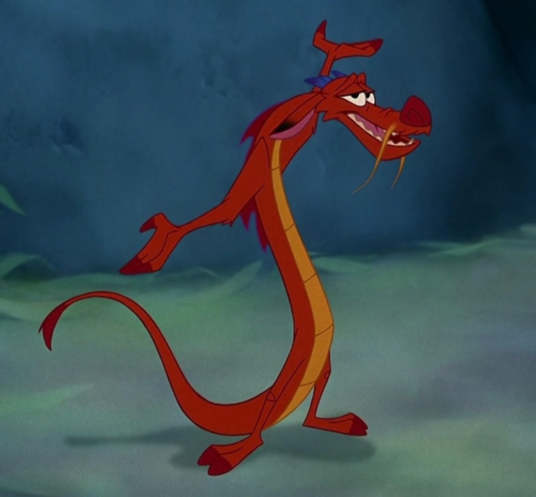

In [ ]:
from cv2 import imread
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path =  "/content/gdrive/MyDrive/Colab Notebooks/ANN3/mushu.jpg"

pic = imread(path)
if pic.all() == None:
    print('Couldnt load the pic, check path')
else:
    print('Loaded picture!')
    pic = imread(path)
    pic = cv2.pyrDown(pic)
    cv2_imshow(pic)


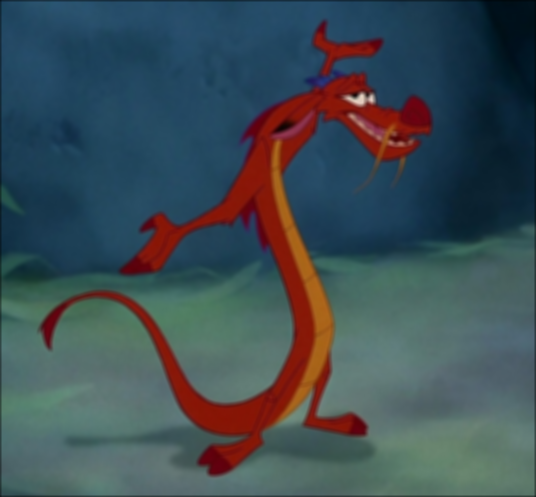

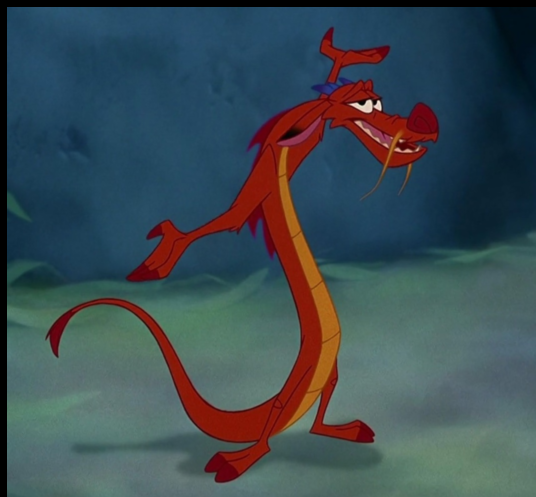

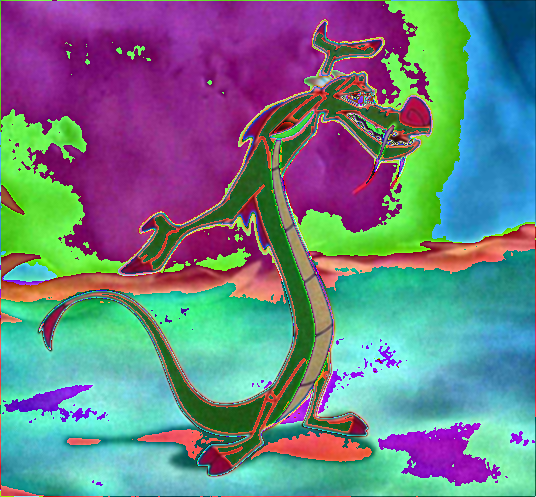

In [ ]:
# Blur filter
x = 1/25
kernel_1 = np.array([[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x]])

# Displacement filter
kernel_2 = np.zeros([15,15])
kernel_2[0,0] = 1

# Color overshoot filter
x = 1
kernel_3 = np.array([[0,x,0],[x,0,x],[0,x,0]])


for kernel in [kernel_1, kernel_2, kernel_3]:
    pic_out = pic.copy()
    for i in [0, 1, 2]:
        pic_out[:,:,i] = conv(pic[:,:,i], kernel)
    cv2_imshow(pic_out)

# Computer Vision
Computer vision (CV) is a task within the computer science field which aim is to extract high level information from static images or video. Such high level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Segmantic segmentation - Classify each and every pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise we will be taking a closer look at object recognition by utilizing transfer learning. The dataset we will use for this exercise can be downloaded on canvas. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into seperate training, validation and test set.

## Task 2: Implement a CNN and train it on the given dataset.

## Task 2: Plain CNN



In [ ]:
# Mount drive and navigate to dir
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
proj_dir =  "/content/gdrive/MyDrive/'Colab Notebooks'/ANN3/datasets_2"

Mounted at /content/gdrive


In [ ]:
######################################################################
##### Some initial inputs...
######################################################################

# Some hyperparams
batch_size = 8
epochs = 50
lr = 1e-5
input_size = 224

In [ ]:
######################################################################
##### Building datasets & loaders
######################################################################

# Specify transforms using torchvision.transforms as transform library
transformations = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set    = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/train", transform = transformations)
valid_set    = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/validation", transform = transformations)
test_set     = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/test", transform = transformations)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=12, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=12, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=14, shuffle=False)

#!sudo apt-get install tree
# !ls /content/gdrive/MyDrive/'Colab Notebooks'/ANN3/dataset_2/
!tree -d /content/gdrive/MyDrive/'Colab Notebooks'/ANN3/dataset_2/

/bin/bash: tree: command not found


In [ ]:
######################################################################
##### Functions that will be used
######################################################################

def get_acc(some_network, some_loader):
    ''' Gets accuracy from a given data loader
    '''
    matches = 0
    samples = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(some_loader):
            preds = some_network(data)

            matches += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            samples += len(labels)

    return matches/samples

def get_preds_labels(some_network, some_loader):
    ''' Gets all the labels and predictions for a given data loader.
    '''
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in some_loader:
                images, labels = batch
                preds = some_network(images)
                preds = np.argmax(preds)
                
                all_preds.append(preds)
                all_targets.append(labels)

        return all_targets, all_preds

Epoch 50, batch 2/2, loss=0.4436976909637451
Finished training!
    > Train acc 1.0
    > Valid acc 0.7916666865348816
    > Test acc 0.6388888955116272
Confusion matrix:
 [[11  7]
 [ 6 12]]


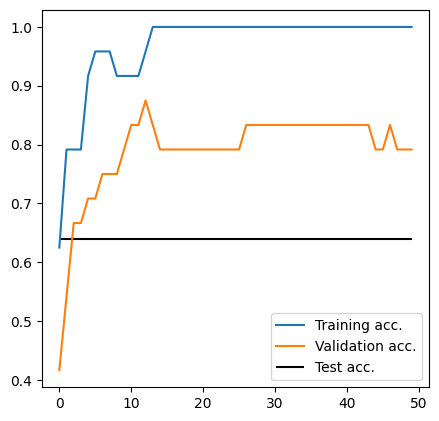

In [ ]:
######################################################################
##### Network & training - No AUG
######################################################################

# Setting up network...
network = nn.Sequential(
    nn.Conv2d(3, 5, 5),
    nn.ReLU(),
    nn.MaxPool2d(5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9680, 100),   
    nn.ReLU(),   
    nn.Linear(100, 2),   
    nn.Softmax(dim=1)
    )   
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=lr)

# Training
train_acc = [];  valid_acc = [] 
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        preds = network(data)
        loss = loss_function(preds, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f'\rEpoch {epoch+1}, batch {i+1}/{len(train_loader)}, loss={loss}', end='')

    train_acc.append(get_acc(network, train_loader))
    valid_acc.append(get_acc(network, valid_loader))


print(f'''\nFinished training!
    > Train acc {train_acc[-1]}
    > Valid acc {valid_acc[-1]}
    > Test acc {get_acc(network, test_loader)}''')


# Confusion matrix
test_loader_1 = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
targets, preds = get_preds_labels(network, test_loader_1)
cm = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % cm)

plt.figure(figsize=(5,5))
plt.plot(train_acc, label='Training acc.')
plt.plot(valid_acc, label='Validation acc.')
plt.hlines(get_acc(network, test_loader), 0, len(valid_acc)-1, label='Test acc.')
plt.legend()
plt.show()

## Task 2.2: CNN with Data Augmentation



Epoch 50, batch 2/2, loss=0.6077175140380859
Finished training!
    > Train acc 0.7083333134651184
    > Valid acc 0.7083333134651184
    > Test acc 0.6666666865348816
Confusion matrix:
 [[ 6 12]
 [ 0 18]]


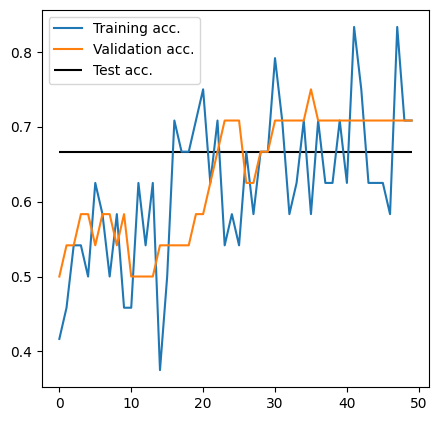

In [ ]:
######################################################################
##### Modifying train dataset & loader WITH AUGMENTATION
######################################################################

# Specify transforms using torchvision.transforms as transform library
transformations_aug = transforms.Compose([
    transforms.RandomAffine(degrees=(10),
                            translate=(0, 0.5),
                            scale=(0.5, 1.5),),
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_set_aug  = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/train", transform = transformations_aug)
train_loader_aug = torch.utils.data.DataLoader(train_set_aug, batch_size=12, shuffle=True)


######################################################################
##### Network & training - No AUG
######################################################################

# Setting up network...
network = nn.Sequential(
    nn.Conv2d(3, 5, 5),
    nn.ReLU(),
    nn.MaxPool2d(5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9680, 100),   
    nn.ReLU(),   
    nn.Linear(100, 2),   
    nn.Softmax(dim=1)
    )   
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=lr)

# Training
train_acc = [];  valid_acc = [] 
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader_aug):
        print(f'\rEpoch {epoch+1}, batch {i+1}/{len(train_loader)}, loss={loss}', end='')

        preds = network(data)
        loss = loss_function(preds, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    train_acc.append(get_acc(network, train_loader_aug))
    valid_acc.append(get_acc(network, valid_loader))


print(f'''\nFinished training!
    > Train acc {train_acc[-1]}
    > Valid acc {valid_acc[-1]}
    > Test acc {get_acc(network, test_loader)}''')


# Confusion matrix
test_loader_1 = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
targets, preds = get_preds_labels(network, test_loader_1)
cm = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % cm)

plt.figure(figsize=(5,5))
plt.plot(train_acc, label='Training acc.')
plt.plot(valid_acc, label='Validation acc.')
plt.hlines(get_acc(network, test_loader), 0, len(valid_acc)-1, label='Test acc.')
plt.legend()
plt.show()

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pretrained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple gpus). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However when we use the pretrained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, as where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in pytorch are trained on [ImageNet](http://www.image-net.org/). 



## Task 3: Fine-tuning - custom



In [ ]:
######################################################################
##### Some initial inputs...
######################################################################
# Decide on model
model_name = "alexnet"

# Some hyperparams
num_classes = 2
batch_size = 8
epochs = 50
lr = 1e-5
input_size = 224

# Flag for feature extracting else fine-tuning
feature_extract = False

In [ ]:
######################################################################
##### Building the dataloaders 
######################################################################

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

proj_dir =  "/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2"

## WITH DATA AUGMENTATION - train and valid
image_datasets_aug = {x: datasets.ImageFolder(os.path.join(proj_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_aug = {x: torch.utils.data.DataLoader(image_datasets_aug[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

## WITHOUT DATA AUGMENTATION - train and valid
image_datasets_vanilla = {x: datasets.ImageFolder(os.path.join(proj_dir, x), data_transforms['validation']) for x in ['train', 'validation']}
dataloaders_vanilla = {x: torch.utils.data.DataLoader(image_datasets_vanilla[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

## AND A TESTLOADER WITH BATCHSIZE 1
test_set = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/test", transform = data_transforms['validation'])
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
######################################################################
##### Functions that will be used
######################################################################

def plot_these(train_acc, valid_acc, test_acc, lab):
    plt.figure(figsize=(5,5))
    plt.plot(train_acc, label='Training acc.')
    plt.plot(valid_acc, label='Validation acc.')
    plt.hlines(test_acc, 0, len(valid_acc)-1, label='Test acc.')
    plt.title(lab)
    plt.legend()


def train_model(network, some_train_loader, some_val_loader, optimizer, criterion, epochs=25, label='No_lab'):
    ''' Train a given model on given data and hyperparams. Does not do test_set
        stuff, only val and training.
    '''
    print(f'Running training "{label}"')
    loss_function = criterion
    train_acc = [];  valid_acc = []

    for epoch in range(epochs):
        for i, (data, labels) in enumerate(some_train_loader): 
            preds = network(data)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            print(f'\rEpoch {epoch+1}, batch {i+1}/{len(some_train_loader)}, loss={loss}', end='')
        
        train_acc.append(get_acc(network, some_train_loader))
        valid_acc.append(get_acc(network, some_val_loader))

    print(f'''\nFinished training!
        > Train acc {train_acc[-1]}
        > Valid acc {valid_acc[-1]}''')

    return network, train_acc, valid_acc


def get_acc(some_network, some_loader):
    ''' Gets accuracy from a given data loader
    '''
    matches = 0
    samples = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(some_loader):
            preds = some_network(data)

            matches += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            samples += len(labels)

    return matches/samples


def get_preds_labels(some_network, some_loader):
    ''' Gets all the labels and predictions for a given data loader.
    '''
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in some_loader:
                images, labels = batch
                preds = some_network(images)
                preds = np.argmax(preds)
                
                all_preds.append(preds)
                all_targets.append(labels)

        return all_targets, all_preds


def set_parameter_requires_grad(model, feature_extracting):
    ''' Use this function to turn off gradients. This is done in feature 
        extracting since we are only modifying the last layers. In finetuning
        this should be left to default value True.
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    ''' Load a model from a set of pretrained ones. This is a crop of the func.
        Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
        Retrieve full function from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    '''
    # Initialize these variables which will be set in this if statement.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size



In [ ]:
######################################################################
##### Instantiating a pretrained model and adapting last layer
######################################################################

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

# Match classifying layer size to our data
model_ft.classifier[6] = nn.Linear(4096, num_classes)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
########################################################################
##### Select which parameters must be tuned and which will be constant
########################################################################

# If we are finetuning we will be updating all parameters.
# If only doing feature extract, we will only update the last layers'.

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


Running training "FineTuning - AugData"
Epoch 50, batch 3/3, loss=0.14311936497688293
Finished training!
        > Train acc 1.0
        > Valid acc 0.625
	> Test acc 0.9166666865348816
[[15  3]
 [ 0 18]]

Running training "FineTuning - VanillaData"
Epoch 50, batch 3/3, loss=0.07514305412769318
Finished training!
        > Train acc 1.0
        > Valid acc 0.8333333134651184
	> Test acc 0.8611111044883728
[[14  4]
 [ 1 17]]



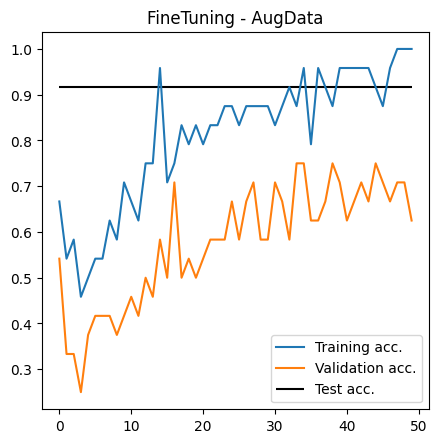

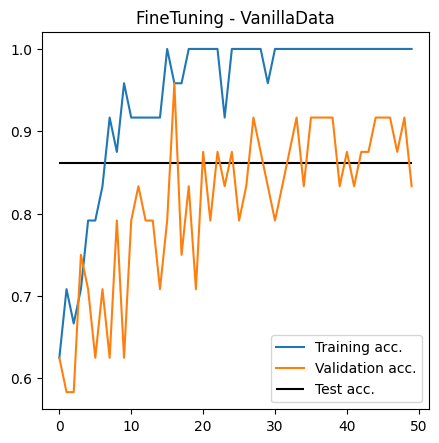

In [ ]:
########################################################################
##### TRAIN AND EVALUATION
########################################################################
# defined at the beggining of section: epochs, lr

#########################################
##### Augmented data
#########################################

# Reset the model - summary of all previous steps
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)
params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Actual training & result display
lab = 'FineTuning - AugData'
network_aug, train_acc, valid_acc = train_model(model_ft, dataloaders_aug['train'], dataloaders_aug['validation'], optimizer_ft, criterion, epochs=epochs, label=lab)

# Set the model to evaluation mode and get test_set results
network_aug.eval()
test_acc = get_acc(network_aug, test_loader)
print(f'\t> Test acc {test_acc}')
plot_these(train_acc, valid_acc, test_acc, lab)

# Compute confusion matrix
targs, preds = get_preds_labels(network_aug, test_loader)
cm = confusion_matrix(targs, preds)
print(f'{cm}\n')


#########################################
##### Vanilla data
#########################################

# Reset the model - summary of all previous steps
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)
params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Actual training & result display
lab = 'FineTuning - VanillaData'
network_vanilla, train_acc, valid_acc = train_model(model_ft, dataloaders_vanilla['train'], dataloaders_vanilla['validation'], optimizer_ft, criterion, epochs=epochs, label=lab)

# Set the model to evaluation mode and get test_set results
network_vanilla.eval()
test_acc = get_acc(network_vanilla, test_loader)
print(f'\t> Test acc {test_acc}')
plot_these(train_acc, valid_acc, test_acc, lab)

# Compute confusion matrix
targs, preds = get_preds_labels(network_vanilla, test_loader)
cm = confusion_matrix(targs, preds)
print(f'{cm}\n')

In [ ]:
# Warning - remember to use this to suppress randomness when regularizating
# network_aug.eval()
# print(network_aug)

## Task 4: Feature extraction - custom



In [ ]:
######################################################################
##### Some initial inputs...
######################################################################
# Decide on model
model_name = "alexnet"

# Some hyperparams
num_classes = 2
batch_size = 8
epochs = 50
lr = 1e-5
input_size = 224

# Flag for feature extracting else fine-tuning
feature_extract = True

In [ ]:
######################################################################
##### Building the dataloaders - EQUAL TO PREVIOUS SECTION'S
######################################################################

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

proj_dir =  "/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2"

## WITH DATA AUGMENTATION - train and valid
image_datasets_aug = {x: datasets.ImageFolder(os.path.join(proj_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_aug = {x: torch.utils.data.DataLoader(image_datasets_aug[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

## WITHOUT DATA AUGMENTATION - train and valid
image_datasets_vanilla = {x: datasets.ImageFolder(os.path.join(proj_dir, x), data_transforms['validation']) for x in ['train', 'validation']}
dataloaders_vanilla = {x: torch.utils.data.DataLoader(image_datasets_vanilla[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

## AND A TESTLOADER WITH BATCHSIZE 1
test_set = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/ANN3/dataset_2/test", transform = data_transforms['validation'])
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
######################################################################
##### Functions that will be used - EQUAL TO PREVIOUS SECTION'S
######################################################################

def plot_these(train_acc, valid_acc, test_acc, lab):
    plt.figure(figsize=(5,5))
    plt.plot(train_acc, label='Training acc.')
    plt.plot(valid_acc, label='Validation acc.')
    plt.hlines(test_acc, 0, len(valid_acc)-1, label='Test acc.')
    plt.title(lab)
    plt.legend()


def train_model(network, some_train_loader, some_val_loader, optimizer, criterion, epochs=25, label='No_lab'):
    ''' Train a given model on given data and hyperparams. Does not do test_set
        stuff, only val and training.
    '''
    print(f'Running training "{label}"')
    loss_function = criterion
    train_acc = [];  valid_acc = []

    for epoch in range(epochs):
        for i, (data, labels) in enumerate(some_train_loader): 
            preds = network(data)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            print(f'\rEpoch {epoch+1}, batch {i+1}/{len(some_train_loader)}, loss={loss}', end='')
        
        train_acc.append(get_acc(network, some_train_loader))
        valid_acc.append(get_acc(network, some_val_loader))

    print(f'''\nFinished training!
        > Train acc {train_acc[-1]}
        > Valid acc {valid_acc[-1]}''')

    return network, train_acc, valid_acc



def get_acc(some_network, some_loader):
    ''' Gets accuracy from a given data loader
    '''
    matches = 0
    samples = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(some_loader):
            preds = some_network(data)

            matches += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            samples += len(labels)

    return matches/samples


def get_preds_labels(some_network, some_loader):
    ''' Gets all the labels and predictions for a given data loader.
    '''
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in some_loader:
                images, labels = batch
                preds = some_network(images)
                preds = np.argmax(preds)
                
                all_preds.append(preds)
                all_targets.append(labels)

        return all_targets, all_preds

        
def set_parameter_requires_grad(model, feature_extracting):
    ''' Use this function to turn off gradients. This is done in feature 
        extracting since we are only modifying the last layers. In finetuning
        this should be left to default value True.
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    ''' Load a model from a set of pretrained ones. This is a crop of the func.
        Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
        Retrieve full function from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    '''
    # Initialize these variables which will be set in this if statement.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size

In [ ]:
######################################################################
##### Instantiating a pretrained model and adapting last layer
######################################################################

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

# Match classifying layer size to our data
model_ft.classifier[6] = nn.Linear(4096, num_classes)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
########################################################################
##### Select which parameters must be tuned and which will be constant
########################################################################

# If we are finetuning we will be updating all parameters.
# If only doing feature extract, we will only update the last layers'.

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Running training "FeatExtract - AugData"
Epoch 50, batch 3/3, loss=0.1888057291507721
Finished training!
        > Train acc 0.9583333134651184
        > Valid acc 0.75
	> Test acc 0.6944444179534912
[[ 8 10]
 [ 1 17]]

Running training "FeatExtract - VanillaData"
Epoch 50, batch 3/3, loss=0.14507630467414856
Finished training!
        > Train acc 1.0
        > Valid acc 0.9166666865348816
	> Test acc 0.8888888955116272
[[14  4]
 [ 0 18]]



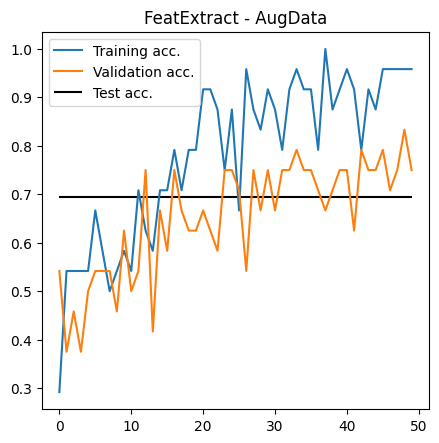

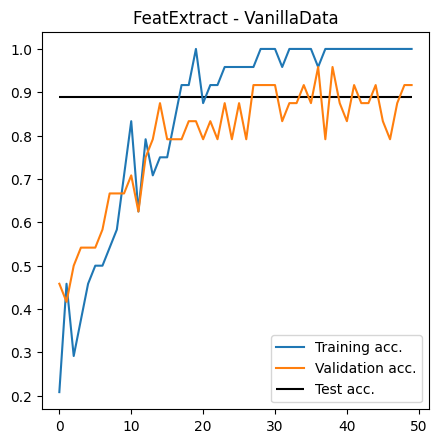

In [ ]:
########################################################################
##### TRAIN AND EVALUATION
########################################################################
# defined at the beggining of section: epochs, lr

#########################################
##### Augmented data
#########################################

# Reset the model - summary of all previous steps
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Actual training & result display
lab = 'FeatExtract - AugData'
network_aug, train_acc, valid_acc = train_model(model_ft, dataloaders_aug['train'], dataloaders_aug['validation'], optimizer_ft, criterion, epochs=epochs, label=lab)

# Set the model to evaluation mode and get test_set results
network_aug.eval()
test_acc = get_acc(network_aug, test_loader)
print(f'\t> Test acc {test_acc}')
plot_these(train_acc, valid_acc, test_acc, lab)

# Compute confusion matrix
targs, preds = get_preds_labels(network_aug, test_loader)
cm = confusion_matrix(targs, preds)
print(f'{cm}\n')


#########################################
##### Vanilla data
#########################################

# Reset the model - summary of all previous steps
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()


# Actual training & result display
lab = 'FeatExtract - VanillaData'
network_vanilla, train_acc, valid_acc = train_model(model_ft, dataloaders_vanilla['train'], dataloaders_vanilla['validation'], optimizer_ft, criterion, epochs=epochs, label=lab)

# Set the model to evaluation mode and get test_set results
network_vanilla.eval()
test_acc = get_acc(network_vanilla, test_loader)
print(f'\t> Test acc {test_acc}')
plot_these(train_acc, valid_acc, test_acc, lab)

# Compute confusion matrix
targs, preds = get_preds_labels(network_vanilla, test_loader)
cm = confusion_matrix(targs, preds)
print(f'{cm}\n')